# NOAA Sea Surface Temperature Optimum Interpolation


## Accessing as a Cloud Native Virtual Dataset

[NOAA Sea Surface Temperature - Optimum Interpolation](https://registry.opendata.aws/noaa-cdr-oceanic/) also known as NOAA OISST, is distributed as a time series of NetCDF formatted HDF5 files. In order to use those files in a cloud optimized way, where we can subset the data by location or time, we can wrap in them with an index (Zarr reference file). Using the AWS STAC API we can discover this virtual Zarr dataset and interact with the underlying data files in a cloud optimized manner.

### How the Reference File Was Made
To generate a reference file for the [NOAA OISST](https://registry.opendata.aws/noaa-cdr-oceanic/) data files we leverage the community driven [Pangeo Forge](https://pangeo-forge.readthedocs.io/en/latest/what_is_pangeo_forge.html) project.  This involves creating a [Pangeo Forge recipe](https://github.com/pangeo-forge/staged-recipes/pull/232) which is [run](https://pangeo-forge.org/dashboard/feedstock/93) using the Pangeo Forge bakery infrastructure that creates an open reference file which points to the underlying data [files](https://noaa-cdr-sea-surface-temp-optimum-interpolation-pds.s3.amazonaws.com/index.html) on S3 made available  via the [Amazon Sustainability Data Initiative](https://sustainability.aboutamazon.com/environment/the-cloud/amazon-sustainability-data-initiative).

> The [Kerchunk](https://fsspec.github.io/kerchunk/) library allows exposing the internal chunk layout of large numbers of gridded scientific data files as a single virtual [Zarr](https://zarr.readthedocs.io/en/stable/index.html) dataset.  This virtual dataset allows users to interact with the data in cloud optimized way by accessing a single Kerchunk [reference file](https://fsspec.github.io/kerchunk/spec.html) entry point without altering or duplicating the underlying source data files.



### Using the Notebook

First we install any necessary packages. Please note that the following block of code only needs to be run if needed within a new workspace and that you may need to restart the kernel to use updated packages. The code block only needs to be run once for each AWS Sagemaker Studio profile.

In [1]:
%pip install 'pystac_client>=0.6.0' xarray zarr s3fs matplotlib -q

Note: you may need to restart the kernel to use updated packages.


### Querying the AWS STAC API with Pystac Client

Using the [Pystac Client](https://pystac-client.readthedocs.io/en/stable/) library we can query the AWS STAC API for the single STAC item available in the `aws-noaa-oisst-avhrr-only` collection.

In [2]:
import fsspec
import xarray as xr
from pystac_client import Client

In [3]:
API_ROOT_URL = "https://dev.asdi-catalog.org/"
client = Client.open(API_ROOT_URL)

search = client.search(collections=["aws-noaa-oisst-avhrr-only"])

item = list(search.items())[0]
item.assets

{'zarr-https': <Asset href=https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/aws-noaa-oisst-feedstock/aws-noaa-oisst-avhrr-only.zarr/reference.json>}

### Opening the Kerchunk Reference File

The returned STAC item for the `aws-noaa-oisst-avhrr-only` dataset has a single asset `zarr-https` which is pointer to the kerchunk reference file.  Using `fsspec` we can generate a file mapping and use the Xarray `open_dataset` operation with `engine=zarr` as if we were working with a Zarr dataset.

In [4]:
fs = fsspec.filesystem("reference", fo=item.assets["zarr-https"].href,
                       remote_protocol="s3", remote_options={"anon":True})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={"consolidated":False})
ds

<xarray.Dataset>
Dimensions:  (time: 15044, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2022-11-08T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    ...                         ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    time_coverage_end:          1981-09-01T23:59:59Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

We can see from the time dimension in the Xarray printout (repr) that the reference file allows us to query and interact with the full 40 years of data.

> **time**     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2022-11-08T12:00:00


### Xarray Selection Operations

Now that we've opened the dataset, we can perform common Xarray selection and slicing operations using the virtual Zarr dataset's dimensions.  These operations will only request chunks from the underlying NetCDF files on S3 that contain data for that selection.  

#### Select Time Series
We can select a month of the sea surface temperature variable's daily measurement and plot its time series.

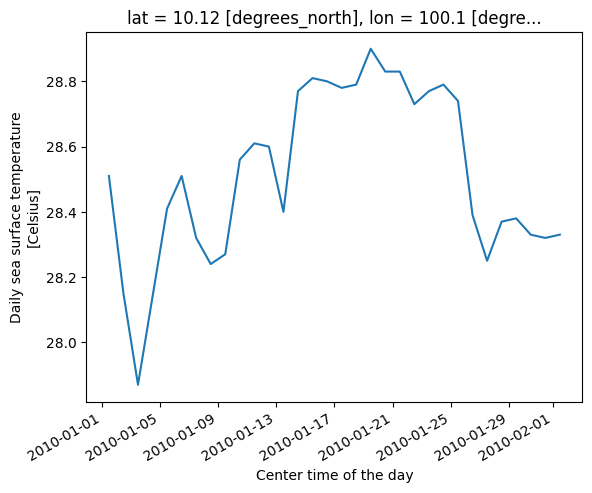

In [5]:
# Select Sea Surface Temperature at a single point over 1 month
point = ds["sst"].sel(lat=10, lon=100, method="nearest")
sst_timeseries = point.sel(time = slice("2010-01-01","2010-02-01")).load()
sst_timeseries.plot()

#### Select Region
We can also change our query and select a range of `lat` `lon` values for a single date and plot the results as an image.

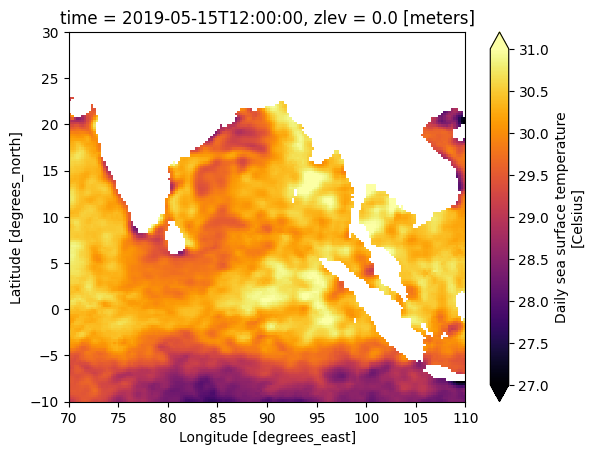

In [6]:
# Select Sea Surface temperature for a single data and region
# Region defined by setting mim, max coordinates with slice
subset = ds["sst"].sel(time="2019-05-15",lat=slice(-10,30),lon=slice(70,110))
subset.plot(vmin=27, vmax=31, cmap="inferno")